# Predicting movie genre from a synopsis.

In [ ]:
import pandas as pd
import chardet
import re as re
import warnings
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from __future__ import division

from scipy.stats import expon as sp_expon
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

from sklearn.base import MetaEstimatorMixin,BaseEstimator, TransformerMixin,ClassifierMixin
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import VotingClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import SelectKBest, SelectPercentile, chi2, f_classif, mutual_info_classif
from sklearn.linear_model import LinearRegression
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, MultiLabelBinarizer


#Models
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC, SVC

## 1. Importando dados de filmes e preparando para análise

In [ ]:
movieData = pd.read_csv('movie.metadata.tsv', sep='\t', header=0, encoding='utf-8',
                        names=["WikipediaID", "FreebaseID", "name", "date", "boxOffice", "runtime",
                               "languages", "countries", "genres"],
                        usecols=["WikipediaID", "name", "date", "languages", "countries", "genres"],
                        index_col=0)
movieData.dropna(subset=['genres'], inplace=True)

In [ ]:
movieData.head()

extrair as informações do gênero




In [ ]:
def extractTags(string):
    return re.findall('"([\w\s]+)"', string)

movieData["genres"] = movieData["genres"].apply(extractTags)
movieData["genres"].loc[3196793]

['Mystery', 'Biographical film', 'Drama', 'Crime Drama']

In [ ]:
movieData["genres"].loc[3196793]

['Mystery', 'Biographical film', 'Drama', 'Crime Drama']

Importando as sinópses para predição.

In [ ]:
file_object  = open('plot_summaries.txt', 'r')

In [ ]:
file_object

<_io.TextIOWrapper name='plot_summaries.txt' mode='r' encoding='UTF-8'>

In [ ]:
import chardet

file_object = open('plot_summaries.txt', 'rb')
rawdata = file_object.read()
encoding_info = chardet.detect(rawdata)
file_object.close()

print(encoding_info)

{'encoding': 'utf-8', 'confidence': 0.99, 'language': ''}


In [ ]:
plot = pd.read_csv("plot_summaries.txt", sep='\t', encoding='utf-8',
                   names=["ident", "synopsis"], index_col=0)

Combinando a sinopse com o resto dos dados.

In [ ]:
result = pd.merge(movieData, plot, left_index=True, right_index=True, how='inner')
result.head()

,name,date,languages,countries,genres,synopsis
WikipediaID,,,,,,
3217,Army of Darkness,1992-10-09,[English Language],[United States of America],"[Cult, Horror, Stop motion, Costume drama, Fan...","After being pulled through a time portal, Ash ..."
3333,The Birth of a Nation,1915,"[Silent film, English Language]",[United States of America],"[Silent film, Indie, Costume drama, Epic, Dram...",The film follows two juxtaposed families: the...
3746,Blade Runner,1982-06-25,"[Japanese Language, Cantonese, English Languag...","[United States of America, Hong Kong]","[Thriller, Cyberpunk, Science Fiction, Future ...","{{Hatnote}} In Los Angeles, November 2019, ret..."
3746,Blade Runner,1982-06-25,"[Japanese Language, Cantonese, English Languag...","[United States of America, Hong Kong]","[Thriller, Cyberpunk, Science Fiction, Future ...","{{Hatnote}} In Los Angeles, November 2019, ret..."
3837,Blazing Saddles,1974-02-07,"[Yiddish Language, English Language]",[United States of America],"[Western, Satire, Comedy]","In the American Old West of 1874, construction..."


### Preparando as labels de treinamento

Precisamos transformar as labels, no momento elas estão assim:

In [ ]:
result.genres[:1]

WikipediaID
3217    [Cult, Horror, Stop motion, Costume drama, Fan...
Name: genres, dtype: object

Essas labels precisam ser binarizadas, como esse é um conjunto de dados conhecido, foi possível encontrar uma lista de gêneros que não são muito descritivos de filmes, e com isso remove-los.

In [ ]:
toDelete = [u'Absurdism', u'Airplanes and airports', u'Albino bias',u'Americana',u'Animal Picture',u'Animals',u'Anthology', u'Anthropology', u'Archaeology',u'Archives and records',u'Art film', u'Beach Film',u'Beach Party film', u'Bengali Cinema',u'Blaxploitation', u'Bollywood',u'British Empire Film', u'British New Wave',u'Buddy film',u'Business', u'Camp',u'Cavalry Film', u'Chase Movie', u'Chinese Movies',u'Christmas movie',u'Cold War',u'Coming of age', u'Computers',u'Cult',u'Cyberpunk', u'Dogme 95', u'Doomsday film',u'Early Black Cinema',u'Education', u'Educational', u'Environmental Science',u'Ensemble Film', u'Escape Film', u'Essay Film', u'Existentialism',u'Experimental film', u'Exploitation', u'Expressionism', u'Fan film', u'Feature film', u'Female buddy film', u'Feminist Film', u'Fictional film', u'Filipino', u'Filipino Movies', u'Film', u'Film adaptation',u'Filmed Play', u'Foreign legion',u'Giallo',u'Goat gland', u'Gothic Film',u'Gross out',u'Hagiography', u'Holiday Film', u'Indie', u'Japanese Movies', u'Journalism',u'Jungle Film', u'Juvenile Delinquency Film',
            u'Kafkaesque', u'Kitchen sink realism', u'Latino', u'Libraries and librarians', u'Linguistics',u'Live action',u'Media Studies',u'Medical fiction',u'Mondo film',u'Movie serial',u'Mumblecore',u'Nature',u'New Hollywood', u'News',u'Northern', u'Nuclear warfare', u'Parkour in popular culture',u'Patriotic film',
            u'Pinku eiga', u'Plague', u'Point of view shot',u'Prison',u'Private military company',u'Propaganda film',u'Reboot', u'Remake', u'Religious Film',u'Roadshow theatrical release',
            u'School story', u'Sexploitation', u'Sponsored film', u'Short Film',u'Singing cowboy', u'Slice of life story',u'Social issues', u'Social problem film', u'Sponsored film', u'Star vehicle',u'Statutory rape', u'Steampunk', u'Stoner film',u'Superhero', u'Superhero movie', u'Surrealism',u'Sword and Sandal', u'Sword and sorcery', u'Sword and sorcery films',  u'Television movie', u'The Netherlands in World War II',u'Tragedy', u'Travel', u'World cinema', u'Wuxia',u'Z movie']

Outro ponto positivo de trabalhar com um conjunto de dados amplamente explorado foi a possíbilidade de uma segunda lista de gêneros que poderiam ser transformados em gêneros únicos, melhorando assim a capacidade de predição.

In [ ]:
toReplace = [(u'Acid western', [u'Western']),(u'Action Comedy', [u'Action', u'Comedy']),(u'Action Thrillers', [u'Action', u'Thriller']),(u'Addiction Drama', [u'Drama']),(u'Adventure Comedy',[u'Adventure', u'Comedy']),(u'Alien Film', [u'Creature Film', u'Science Fiction']),(u'Alien invasion', [u'Creature Film', u'Science Fiction']),(u'Animated Musical', [u'Animation']),(u'Animated cartoon', [u'Animation']),(u'Anime', [u'Animation']),(u'Auto racing', [u'Sports']),(u'Backstage Musical', [u'Musical']),(u'Baseball', [u'Sports']),(u'Biker Film', [u'Road movie']),(u'Biographical film', [u'Biography']),(u'Black comedy', [u'Comedy']),(u'Boxing', [u'Sports']),(u'Breakdance', [u'Dance']),(u'Buddy cop', [u'Crime']),(u'Caper story', [u'Crime', u'Comedy']),(u'Chick flick', [u'Romance']),(u'Childhood Drama',[u'Drama']),(u'Christian film', [u'Religious Film']),(u'Clay animation', [u'Animation']),
             (u'Combat Films', [u'Action']),(u'Comdedy',[u'Comedy']),(u'Comedy Thriller', [u'Comedy', u'Thriller']),(u'Comedy Western', [u'Comedy', u'Western']),(u'Comedy film', [u'Comedy']),(u'Comedy horror', [u'Comedy', u'Horror']),(u'Comedy of Errors', [u'Comedy']),(u'Comedy of manners', [u'Comedy']),(u'Computer Animation', [u'Animation']),(u'Concert film', [u'Music']),(u'Conspiracy fiction', [u'Thriller']),(u'Costume Adventure', [u'Adventure']),(u'Costume Horror', [u'Horror']),(u'Costume drama', [u'Drama']),(u'Courtroom Comedy',[u'Courtroom', u'Comedy']),(u'Courtroom Drama',[u'Courtroom', u'Drama']),(u'Creature Film', [u'Monster']), (u'Crime Comedy', [u'Crime', u'Comedy']),(u'Crime Drama', [u'Crime', u'Drama']),(u'Crime Fiction', [u'Crime']),(u'Crime Thriller', [u'Crime', u'Thriller']),(u'Demonic child', [u'Horror']),(u'Detective fiction', [u'Detective']),(u'Docudrama', [u'Drama']),(u'Domestic Comedy', [u'Comedy']),(u'Ealing Comedies', [u'Comedy']),(u'Epic Western', [u'Epic', u'Western']),(u'Erotic Drama', [u'Adult', u'Drama']),(u'Erotic thriller', [u'Adult', u'Thriller']),(u'Erotica', [u'Adult']),(u'Extreme Sports', [u'Sports']),(u'Family Drama', [u'Family Film', u'Drama']),
             (u'Fairy Tale', [u'Fantasy']),(u'Fairy tale', [u'Fantasy']),(u'Fantasy Adventure', [u'Fantasy', u'Adventure']),(u'Fantasy Comedy', [u'Fantasy', u'Comedy']),(u'Fantasy Drama', [u'Fantasy', u'Drama']),(u'Future noir', [u'Film noir']),(u'Gangster Film', [u'Crime']),(u'Gay', [u'LGBT']),(u'Gay Interest', [ u'LGBT']),(u'Gay Themed', [ u'LGBT']), (u'Gay pornography', [ u'LGBT', u'Adult']),(u'Gender Issues', [u'LGBT']),(u'Glamorized Spy Film', [u'Spy']),
             (u'Gulf War', [u'War film']),(u'Haunted House Film', [u'Horror']),(u'Hardcore pornography', [u'Adult']),(u'Heavenly Comedy', [u'Comedy']),(u'Heist', [u'Crime']),(u'Hip hop movies', [u'Music']),(u'Historical Documentaries', [u'History', u'Documentary']),(u'Historical Epic', [u'History']),(u'Historical drama', [u'History']),(u'Historical Drama', [u'History', u'Drama']),(u'Historical fiction', [u'History']),(u'Homoeroticism', [u'Adult', u'LGBT']),(u'Horror Comedy', [u'Horror', u'Comedy']),(u'Horse racing', [u'Sport']),(u'Humour', [u'Comedy']),(u'Hybrid Western', [u'Western']),(u'Indian Western', [u'Western']),(u'Inspirational Drama', [u'Drama']),(u'Instrumental Music', [u'Music']),(u'Interpersonal Relationships', [u'Drama']),(u'Jukebox musical', [u'Musical']),(u'Legal drama', [u'Courtroom']),(u'Marriage Drama', [u'Drama']),(u'Master Criminal Films', [u'Crime']),(u'Media Satire', [u'Comedy']),
             (u'Melodrama', [u'Drama']),(u'Mockumentary', [u'Comedy']),(u'Monster movie', [u'Monster']),(u'Movies About Gladiators', [u'History', u'Action']),(u'Musical Drama', [u'Musical', u'Drama']),(u'Musical comedy', [u'Musical', u'Comedy']), (u'Mythological Fantasy',[u'Fantasy']),(u'Natural disaster', [u'Disaster']), (u'Natural horror films', [u'Horror']),(u'Ninja movie', [u'Martial Arts Film']),(u'Operetta', [u'Musical']),(u'Outlaw', [u'Crime']),(u'Outlaw biker film', [u'Crime', u'Road movie']),(u'Parody', [u'Comedy']),(u'Period Horror', [u'Period', u'Horror']),(u'Period piece', [u'Period']),(u'Political cinema', [u'Politics']),(u'Political drama', [u'Politics', u'Drama']),(u'Political satire', [u'Politics', u'Comedy']),(u'Political thriller', [u'Politics', u'Thriller']),(u'Pornographic movie', [u'Adult']),(u'Pornography', [u'Adult']),(u'Prison', [u'Crime']),(u'Prison escape', [u'Crime']),(u'Prison film', [u'Crime']),(u'Psychological horror', [u'Horror']),(u'Psychological thriller', [u'Thriller']),
             (u'Punk rock', [u'Music']),(u'Race movie', ['Sports']),(u'Revisionist Fairy Tale', [u'Fantasy']),(u'Revisionist Western', [u'Western']),(u'Rockumentary', [u'Documentary', u'Music']),(u'Romance Film', [u'Romance']),(u'Romantic Film', [u'Romance']),(u'Romantic comedy', [u'Romance', u'Comedy']),(u'Romantic drama', [u'Romance', u'Drama']),(u'Romantic fantasy', [u'Romance', u'Fantasy']),(u'Samurai cinema', [u'Martial Arts Film']),(u'Satire', [u'Comedy']),(u'Sci Fi Pictures original films', [u'Science Fiction']),(u'Science fiction Western', [u'Science Fiction', u'Western']),(u'Screwball comedy', [u'Comedy']),(u'Sex comedy', [u'Comedy']),(u'Slapstick', [u'Comedy']),(u'Slasher', [u'Horror']),(u'Softcore Porn', [u'Adult']),(u'Space opera', [u'Science Fiction', u'Musical']),(u'Space western', [u'Science Fiction', u'Western']),(u'Spaghetti Western', [u'Western']),(u'Spaghetti western', [u'Western']),(u'Splatter film', [u'Horror']),(u'Sport', [ u'Sports']),(u'Stop motion', [u'Animation']),(u'Supermarionation', [u'Animation']),(u'Swashbuckler films', [u'Adventure']),
             (u'Therimin music', [u'Music']), (u'Time travel', [u'Science Fiction']),(u'Tragicomedy', [u'Comedy', u'Tragedy']),(u'Vampire movies', [u'Horror']),(u'War effort', [u'War film']),(u'Werewolf fiction', [u'Monster']),(u'Whodunit', [u'Detective']),(u'Women in prison films', [u'Prison']),(u'World History', [u'History']),(u'Workplace Comedy', [u'Comedy']),(u'Zombie Film', [u'Monster'])]

Aas funções a seguir são para mudar ou remover os gêneros de acordo com as listas acima.

In [ ]:
class wordRemover():
    def __init__(self, word):
        self.word = word

    def removeWord(self, listOfWords):
        if self.word in listOfWords:
            index = listOfWords.index(self.word)
            del listOfWords[index]
        return listOfWords

In [ ]:
class wordReplacer():
    def __init__(self, word, replacements):
        self.word = word
        self.replacements = replacements

    def replaceWord(self, listOfWords):
        if self.word in listOfWords:
            index = listOfWords.index(self.word)
            del listOfWords[index]
            for replacement in self.replacements:
                if replacement not in listOfWords:
                    listOfWords.append(replacement)
        return listOfWords

In [ ]:
for word in toDelete:
    result.genres = result.genres.apply(wordRemover(word).removeWord)

for word, replacements in toReplace:
    result.genres = result.genres.apply(wordReplacer(word, replacements).replaceWord)


Agora binarizando as labels, encontramos 40 labels unicas

In [ ]:
binarizer = MultiLabelBinarizer()
y = binarizer.fit_transform(result.genres)

In [ ]:
binarizer.classes_

array(['Action', 'Adult', 'Adventure', 'Animation', 'Biography', 'Comedy',
       'Courtroom', 'Crime', 'Dance', 'Detective', 'Disaster',
       'Documentary', 'Drama', 'Dystopia', 'Epic', 'Family Film',
       'Fantasy', 'Film noir', 'History', 'Horror', 'LGBT',
       'Martial Arts Film', 'Monster', 'Music', 'Musical', 'Mystery',
       'Period', 'Politics', 'Prison', 'Religious Film', 'Road movie',
       'Romance', 'Science Fiction', 'Silent film', 'Sports', 'Spy',
       'Supernatural', 'Suspense', 'Teen', 'Thriller', 'Tragedy',
       'War film', 'Western'], dtype=object)

Os dados de gêneros são armazenados como 1s e 0s.

In [ ]:
y[:1]

array([[1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

Podemos fazer a operação inversa para descobrirmos qual gênero o vetor representa.

In [ ]:
binarizer.inverse_transform(y[:1])

[('Action',
  'Animation',
  'Comedy',
  'Drama',
  'Fantasy',
  'Horror',
  'Monster',
  'Science Fiction')]

Agoras vamos fazer o split nos dados para treino e teste.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(result.synopsis,y,
                                                    train_size=0.7, random_state = 9588)

Plotando a distribuição de gêneros no dataset.

Text(0, 0.5, 'Número de generos')

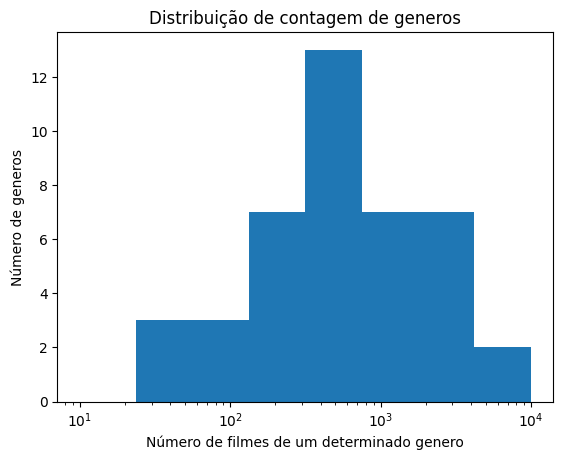

In [ ]:
labelCounts = y_train.sum(axis=0)
n, bins, patches = plt.hist(labelCounts, bins=np.logspace(1, 4, 9))
plt.semilogx()
plt.title("Distribuição de contagem de gêneros")
plt.xlabel("Número de filmes de um determinado gênero")
plt.ylabel("Número de gêneros")

## 2. Análises de Feature

Fazendo analise em cima de Comedy, devido a sua grande representatividade no dataset.

In [ ]:
genreDF = pd.DataFrame(y_train, columns = binarizer.classes_)
genreDF.Comedy.sum()/genreDF.Comedy.count()

0.35711963589076723

na verdade essa tag está presente em aproximadamente 5% do training set.

In [ ]:
X_train.str.contains("{{\w*}}", case=False).mean()

0.045405288253142606

O ideal é que um transformer seja criado para resover esse problema de maneira que possa ser adicionado em uma pipeline.

In [ ]:
def deleteSynopsisTags(X):
    return X.str.replace("\s*{{\w*}}\s*", "", case=False)

deleteSynopsisTagsTransformer = FunctionTransformer(deleteSynopsisTags, validate=False)

X_wrangle_1 = deleteSynopsisTagsTransformer.fit_transform(X_train)

Podemos então ver que o problema da tag foi resolvido.

In [ ]:
X_wrangle_1.loc[1952976][:24]

Precisamos escolher uma métrica adequada para avaliar os modelos. F1 será nossa escolha devido a sua capacidade de balancear precisão e acurácia. Abaixo segue sua implementação para uma única classe, iremos extender isso para frente.

In [ ]:
def customF1(hat, actual, **kwargs):
    accuracy = ((actual*hat).sum())/actual.sum()
    precision = ((actual*hat).sum())/hat.sum()
    if accuracy==0 or precision==0:
        f1= 0
    else:
        f1= 2.* pow(pow(accuracy, -1) + pow(precision, -1), -1)
    return f1
customF1Scorer = make_scorer(customF1, greater_is_better=True)

Agora podemos ir em direção de encontrar features mais importantes para a qualidade do treinamento. No código a seguir podemos vetorizar as sinopses e printar as 200 palavras mais importantes que dizem se um filme é uma comédia ou não usando $\chi^2$. Então seguimos realizando um treinamento com as features mais importantes e printando o resultado do cross validation e de treinamento. Imprimir os dois é uma prática interessante para determinar overfitting.

In [ ]:
def mostImportantFeatrures(X, y):
    count = CountVectorizer(lowercase=False, strip_accents='unicode', min_df = 3, stop_words='english')
    selector = SelectKBest(chi2, k=200)
    X_Vec = count.fit_transform(X, y)
    X_select = selector.fit_transform(X_Vec, y)
    print(np.unique([name for name, val in zip(count.get_feature_names_out(), selector.get_support()) if val==True]))
    MultinomialPipe = Pipeline([
                                ("count", count),
                                ("selector", SelectPercentile(chi2)),
                                ("model", MultinomialNB(alpha = 1e-9, fit_prior=False))
                               ])
    rs = RandomizedSearchCV(MultinomialPipe, param_distributions={"selector__percentile":sp_randint(1, 50)},
                            n_iter=10,
                            scoring=customF1Scorer, verbose=0,
                            refit=True, n_jobs=-1,
                            cv=3
                           )
    rs.fit(X, y)
    print("grid search best score = ", rs.best_score_)
    print("grid search best param = ", rs.best_params_)
    hYat = rs.predict(X)
    print("score on training data = ", customF1(y, hYat))

In [ ]:
mostImportantFeatrures(X_wrangle_1, genreDF.Comedy)

Podemos ver que a maioria das features mais prevalentes são nomes. Embora nomes possam contribuir para predição, é mais provavavel que a repetição de nomes cause overfitting. Devemos remove-los.

In [ ]:
def noCaps(X):
    return X.str.replace(r'([A-Z])\w+', "", case=True)

noCapsTransform = FunctionTransformer(noCaps, validate=False)

X_wrangle_2 = noCapsTransform.fit_transform(X_wrangle_1)
mostImportantFeatrures(X_wrangle_2, genreDF.Comedy)

In [ ]:
from nltk.stem.porter import *
from nltk import tokenize
stemmer = PorterStemmer()
tokenizer = tokenize.WordPunctTokenizer()
def stemCustom(X):
    splitStemJoin = lambda string: ' '.join([stemmer.stem(word) for word in tokenizer.tokenize(string)])
    return X.apply(splitStemJoin)

stemTransform = FunctionTransformer(stemCustom, validate=False)

X_wrangle_3 = stemTransform.fit_transform(X_wrangle_2)
mostImportantFeatrures(X_wrangle_3, genreDF.Comedy)

In [ ]:
mostImportantFeatrures(X_wrangle_3, genreDF.Documentary)

Podemos ver que o fit foi bem pior do que foi para comédia, e podemos notar a presença de números, vamos remove-los.

In [ ]:
def noDigits(X):
    return X.str.replace(r'\d+\,?\.?\d?', "")

noDigitsTransform = FunctionTransformer(noDigits, validate=False)

X_wrangle_4 = noDigitsTransform.fit_transform(X_wrangle_3)

In [ ]:
mostImportantFeatrures(X_wrangle_4, genreDF.Documentary)

Agora podemos tranformar a sinopse vetorizada em um array numpy e juntar todos os passos em uma pipeline de pré-processamento.

In [ ]:
import numpy as np

def transformToNp(X):
    return np.array(X).flatten()

transformToNpTransform = FunctionTransformer(transformToNp, validate=False)

X_wrangled = transformToNpTransform.fit_transform(X_wrangle_4)

preprocessing = Pipeline([("deleteTags", deleteSynopsisTagsTransformer),
                          ("deleteCapitalizedWords", noCapsTransform),
                          ("porterStemmer", stemTransform),
                          ("deleteDigits", noDigitsTransform),
                          ("toNumpy", transformToNpTransform)])



## 3. Dummy model


Antes de partirmos para um dummy model, precisamos generalizar o f1 para multilabel.

In [ ]:
def averageF1Micro(y, yPredicted, **kwargs):
    return np.mean([f1_score(sub_y, sub_ypredicted, labels=[1], average='micro')
                    if sum(sub_ypredicted)!=0 else 0
                    for sub_y, sub_ypredicted in zip(y,yPredicted) if sum(sub_y)!=0] )

averageF1MicroScorer = make_scorer(averageF1Micro, greater_is_better=True)

In [ ]:
def nMostFrequent(n):
    assert(n>0)
    frequencies=(genreDF.sum()/genreDF.count())
    nMostFrequent = (frequencies.sort_values()[-n:]).index.tolist()
    return nMostFrequent

As 5 labels mais frquenes são:

In [ ]:
nMostFrequent(5)

['Crime', 'Romance', 'Thriller', 'Comedy', 'Drama']

Agora algo que podemos fazer é encontrar com o dummy model as labels mais frequentes para cada filme, então usando cross validation, vamos encontrar o número com melhor pontuação.

In [ ]:
class nMostFrequentClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n=1):
        self.n = n

    def fit(self, X, y):
        self.occurences_ = np.sum(y, axis=0)
        return self

    def predict(self, X):
        cutOffVal = np.sort(self.occurences_, axis=0)[-self.n]
        if (self.occurences_==cutOffVal).sum()==1:
            self.nMostFrequent_ = self.occurences_>=cutOffVal
        else:
            additionalToSelect = self.n - (self.occurences_>cutOffVal).sum()
            indexesOfAdditionals = np.argwhere(np.array([0,1,1,1])==1)[:additionalToSelect]
            additionals = np.array([[1 if i in indexesOfAdditionals else 0 for i in range(len(self.occurences_))]])
            self.nMostFrequent_ = additionals + self.occurences_>cutOffVal
        numPredicted = len(X)
        return np.array([self.nMostFrequent_.tolist()]*numPredicted)

Vamos tentar predizer as 10 labels mais frequentes e plotar os resultados

In [ ]:
pipeDummy = Pipeline([("nMostFrequent", nMostFrequentClassifier())])

dummCV = GridSearchCV(pipeDummy, param_grid={"nMostFrequent__n":[1,2,3,4,5,6,7,8,9,10]},
                          scoring=averageF1MicroScorer, verbose=1,
                          refit=False, n_jobs=-1, cv=3)
dummCV.fit(X_wrangled, y_train)
print("    best score", dummCV.best_score_)
print("    best param", dummCV.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
    best score 0.35961446047661566
    best param {'nMostFrequent__n': 2}


(0.24, 0.38)

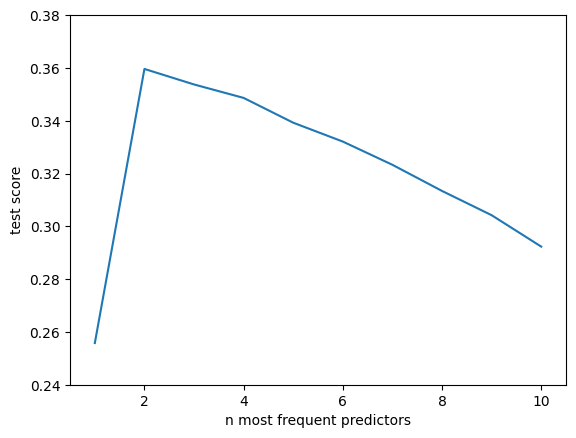

In [ ]:
plt.plot(range(1, 11), dummCV.cv_results_["mean_test_score"])
plt.ylabel("test score")
plt.xlabel("n preditores mais frequentes")
plt.xlim([0.5, 10.5])
plt.ylim([0.24, 0.38])

# 4. Multilabel classification classes

Como iremos apliacar algoritmos de ML para cada label, alguns podemo aparecer pouquissimas vezes no dataset. Precisamos de uma classe que que não tentara treinar nesse tipo dedado, mas apenas retornar zero nesses casos.

In [ ]:
class MinSampleClassifier(BaseEstimator, MetaEstimatorMixin):
    def __init__(self, clf=MultinomialNB(), limit=10, decisionFunction=False):
        self.clf = clf
        self.limit = limit
        self.decisionFunction = decisionFunction

    def fit(self, X, y):
        if sum(y)<self.limit:
            self.dataTooSmall_ = True
        else:
            self.dataTooSmall_ = False
            self.clf.fit(X,y)
        return self

    def predict(self, X):
        if self.dataTooSmall_:
            return np.array([np.array([0.])]*X.shape[0])
        else:
            return self.clf.predict(X)

    def decision_function(self, X):
        if self.dataTooSmall_:
            return np.array([np.array([0.])]*X.shape[0])
        elif self.decisionFunction:
            return self.clf.decision_function(X)
        else:
            return self.clf.predict_proba(X)[:,1]

Os modelos se enquadram em duas categorias. Aqueles, como naive bayes, que podem prever a probabilidade de um determinado ponto de dados ter um rótulo específico e aqueles que utilizam uma função de decisão. Em ambos os casos, há um valor de corte abaixo do qual um ponto de dados é considerado pelo modelo como não tendo esse rótulo, para abordagens que prevêem uma probabilidade esse valor é 0,5 e para modelos que possuem uma função de decisão o valor é 0 (que é o distância de algum limite de decisão). No entanto, esses valores podem não levar à melhor pontuação de f1 e eu gostaria de poder ajustar o limite para obter o melhor ajuste.

Vou criar um processo de duas etapas. Primeiro, pegarei um algoritmo de aprendizado de máquina e o usarei para transformar os dados em uma medida de ajuste, seja uma probabilidade ou uma pontuação de função de decisão.

In [ ]:
class PredictionTransformer(BaseEstimator, TransformerMixin, MetaEstimatorMixin):
    def __init__(self, clf=MultinomialNB(), decisionFunction=True):
        """Replaces all features with `clf.predict_proba(X)`"""
        self.clf = clf
        self.decisionFunction=decisionFunction

    def fit(self, X, y):
        self.clf.fit(X, y)
        return self

    def transform(self, X):
        if self.decisionFunction:
            return self.clf.decision_function(X)
        else:
            X_array = np.asarray(X)
            probs = self.clf.predict_proba(X)
            return [val[:,1] if val.shape[1]==2 else [0]*val.shape[0] for val in probs ]



A seguir criarei uma classe que permite aumentar ou diminuir o valor do limite. No entanto, isso pode levar a situações em que nenhum rótulo seja previsto. Neste caso, quero prever os n rótulos com as pontuações ou probabilidades mais altas, mesmo que sejam bastante baixas. Um método alternativo seria prever os n rótulos mais frequentes se nenhum deles tivesse uma probabilidade suficientemente alta. Descobri que essa alternativa leva a resultados inferiores.

In [ ]:
def thresholdCalc(threshold, minCount, x):
    initialThreshold = x>=threshold
    if initialThreshold.sum() >=minCount:
        return initialThreshold
    else:
        indexes = np.argpartition(x, -minCount)[-minCount:]
        lowerThreshold = x[indexes].min()
        if lowerThreshold>0 and minCount<len(x):
            return x>=lowerThreshold
        else:
            return x>0

class ThresholdClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, threshold=0.5, minCount = 2, transpose=True):
        self.threshold = threshold
        self.minCount = minCount
        self.transpose=transpose

    def fit(self, X, y):
        return self

    def predict(self, X):
        X_array = np.asarray(X)
        if self.transpose:
            returnVal = np.array([thresholdCalc(self.threshold, self.minCount, sub) for sub in X_array]).T
        else:
            returnVal = np.array([thresholdCalc(self.threshold, self.minCount, sub) for sub in X_array])
        return returnVal

    def predict_proba(self, X):
        return X

## 5. Defining and tuning models

O ideal é que todos modelos tenham seus parâmetros tunados usando cross validation. Criaremos código que aplicará essa técnica em cada um dos modelos para podermos encotnrar os melhores parâmetros.

In [ ]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

def crossValidateRandom(X, Y, model, params=None, n_iter=100):
    rsCV = RandomizedSearchCV(model, param_distributions=params, n_iter=n_iter,
                            scoring=averageF1MicroScorer, verbose=1,
                            refit=False, n_jobs=-1,
                            cv=3
                           )
    fittedModel = rsCV.fit(X, Y)
    report(rsCV.cv_results_)
    return rsCV.best_params_

In [ ]:
count = CountVectorizer(lowercase=False, strip_accents='unicode', stop_words='english')

# Naive Bayes


Este modelo é a base de qualquer tentativa de análise de texto. Para este modelo, criarei um modelo bayesiano ingênuo para cada gênero e, em seguida, usarei o preditor de limite para encontrar os rótulos mais prováveis.

Alguns dos parâmetros que desejo examinar devem ser sampled uniformly, como o limite e a porcentagem de recursos necessários para melhor prever cada rótulo. Outros parâmetros precisam ser amostrados uniformemente no espaço logarítmico, como $\alpha$ que suaviza a função de likelihood de cada recurso. Para isso eu crio uma distribuição personalizada rápida

In [ ]:
class logUniform():
    def __init__(self, low = -9, high = 0):
        self.rng = sp_uniform(low, high-low)
    def rvs(self, **kwargs):
        return 10**(self.rng.rvs(**kwargs))

In [ ]:
selectThenNBPipe = Pipeline([("selector", SelectPercentile(chi2)),
                             ("prediction",MultinomialNB())])

multipleNB = OneVsRestClassifier(MinSampleClassifier(selectThenNBPipe, decisionFunction=False))

naiveBayes = Pipeline([("count",count),
                       ("model", PredictionTransformer(clf=multipleNB)),
                       ("threshold", ThresholdClassifier(transpose=False))])

NBparams = {"count__max_df":sp_uniform(0.8, 1.0),
            "count__min_df":sp_randint(1,4),
            "model__clf__estimator__clf__prediction__alpha":logUniform(low=-12, high=0),
            "model__clf__estimator__clf__prediction__fit_prior":[True, False],
            "model__clf__estimator__clf__selector__percentile":sp_randint(1, 100),
            "threshold__threshold":sp_uniform(0, 0.5),
            "threshold__minCount":sp_randint(2, 6)
           }

NBModelBestParams = crossValidateRandom(X_wrangled, y_train, naiveBayes, params=NBparams, n_iter=120)
naiveBayes.set_params(**NBModelBestParams)

Vemos que o melhor resultado do cross validation foi 0.53. É um bom resultado, mas vamos continuar explorando novos modelos.

# Random Forest


Este modelo é mais fácil de aplicar do que naive bayes, pois lida nativamente com vários labels. No entanto, ainda preciso aplicar o limite. Este modelo foi muito lento para se ajustar à presença de milhares de recursos.

In [ ]:
randomForest = Pipeline([("count", count),
                         ("TruncatedSVD", TruncatedSVD(n_components=100)),
                         ("model", PredictionTransformer(clf=RandomForestClassifier(), decisionFunction=False)),
                         ("prob", ThresholdClassifier())
                        ])

multiRFParams={
               "model__clf__n_estimators":[15, 20, 25],
               "model__clf__max_depth":[10, 20, 25],
               "model__clf__min_samples_split":[3,5,7],
               "prob__threshold":[0.4, 0.5],
               "prob__minCount":[2,3,4]
              }

randomRFParams={
                "count__max_df":sp_uniform(0.0, 1.0),
                "count__min_df":sp_randint(1,4),
                "model__clf__n_estimators":sp_randint(10, 30),
                "model__clf__max_depth":sp_randint(5, 50),
                "model__clf__min_samples_split":sp_randint(2, 8),
                "prob__threshold":sp_uniform(0, 0.5),
                "prob__minCount":sp_randint(2, 6)
               }

randomForestBestParams = crossValidateRandom(X_wrangled, y_train, randomForest,
                                             params=randomRFParams, n_iter=120)
randomForest.set_params(**randomForestBestParams)

Uma pontuação de 0.459, mas não é o melhor resultado esperado para esse modelo, possívelmente uma aumento de performance viria de um aumento em n_estimators>

# Support Vector Machines

Os modelos SVM são incrivelmente poderosos, mas podem ser muito lentos para ajustar e prever na presença de um grande número de features. Isso é agravado pela necessidade de ajustar um modelo específico para cada um dos 40 rótulos. Por esta razão escolhi o modelo SVC linear simples; modelos mais sofisticados simplesmente eram lentos demais para serem usados.

In [ ]:
selectThenLinearSVCPipe = Pipeline([("selector", SelectPercentile(chi2)),
                                    ("prediction",LinearSVC())
                                   ])

multiplieSVC = OneVsRestClassifier(MinSampleClassifier(selectThenLinearSVCPipe, decisionFunction=True))

linearSVC = Pipeline([("count",count),
                      ("model", PredictionTransformer(multiplieSVC)),
                      ("threshold", ThresholdClassifier(transpose=False))
                     ])

randomSVCparams = {
                   "count__max_df":sp_uniform(0.8, 1.0),
                   "count__min_df":sp_randint(1,4),
                   "model__clf__estimator__clf__prediction__C":logUniform(low=-9, high=0),
                   "model__clf__estimator__clf__prediction__loss":["hinge", "squared_hinge"],
                   "model__clf__estimator__clf__prediction__class_weight":["balanced", None],
                   "model__clf__estimator__clf__selector__percentile":sp_randint(1, 100),
                   "threshold__threshold":sp_uniform(0, 5),
                   "threshold__minCount":sp_randint(2, 6)
                  }

linearSVCBestParams = crossValidateRandom(X_wrangled, y_train, linearSVC,
                                          params=randomSVCparams, n_iter=120)

linearSVC.set_params(**linearSVCBestParams)

o resultado foi 0.513, o que é um bom resultado mas ainda não o melhor.

# Stochastic Gradient Descent Classifier


Finalmente, uso o Stochastic Gradient Descent Classifier que é muito rápido. Este modelo ajusta uma função de decisão linear de acordo com diferentes mecanismos de loss. Por exemplo, usar loss de log é equivalente a ajustar uma regressão logística. Aqui tentamos várias funções de perda diferentes.

In [ ]:
selectThenSGDCPipe = Pipeline([("selector", SelectPercentile(chi2)),
                               ("prediction",SGDClassifier())
                              ])

multipleSGDC = OneVsRestClassifier(MinSampleClassifier(selectThenSGDCPipe, decisionFunction=True))

SGDC = Pipeline([("count",count),
                 ("model", PredictionTransformer(multipleSGDC)),
                 ("threshold", ThresholdClassifier(transpose=False))
                ])

SGDCparams = {
              "count__max_df":sp_uniform(0.8, 1.0),
              "count__min_df":sp_randint(1,4),
              "model__clf__estimator__clf__prediction__alpha":logUniform(low=-9, high=0),
              "model__clf__estimator__clf__prediction__loss":["log", "modified_huber", "perceptron"],
              "model__clf__estimator__clf__prediction__penalty":["none", "l2", "l1", "elasticnet"],
              "model__clf__estimator__clf__prediction__n_iter":sp_randint(2, 20),
              "model__clf__estimator__clf__selector__percentile":sp_randint(1, 100),
              "threshold__threshold":sp_uniform(1, 5),
              "threshold__minCount":sp_randint(2, 6)
             }

SGDCBestParams = crossValidateRandom(X_wrangled, y_train, SGDC,
                                         params=SGDCparams, n_iter=120)
SGDC.set_params(**SGDCBestParams)

A pontuação final foi de 0.459.

# Voting

Agora para finalizar vamos tentar combinar esse modelos para ver se chegamos em um poder de previsão maior. Scikit-Learn possui um ensemble classifiers mas sem suporte para multilabel classification, então precisamos adaptar a classe VotingClassifier.

In [ ]:
class MultiLabelVotingClassifier(VotingClassifier):
    def fit(self, X, Y):
        self.estimators_ = [clf.fit(X, Y) for _, clf in self.estimators]
        return self

    def predict(self, X):
        predictions = self._predict(X)
        maj = np.array([np.apply_along_axis(lambda x:np.argmax(np.bincount(x, weights=self.weights)), axis=1, arr=y.astype('int')).tolist() for y in predictions]).T
        return maj

Podemos tentar combinações diferentes de modelos e dar pesos diferentes para cada modelo, mas o número de modelos precisa ser ímpar.

In [ ]:
binaries = [[a,b,c,d] for a in [0,1] for b in [0,1] for c in [0,1] for d in [0,1] if (a+b+c+d)%2==1]
sub2for0 = lambda lst : [2 if val==0 else val for val in lst]
weights = binaries + [sub2for0(lst) for lst in binaries]
weights

In [ ]:
ensembleModel =  MultiLabelVotingClassifier(estimators = [("NBModel",naiveBayes),
                                                          ("randomForestModel",randomForest),
                                                          ("linearSVCModel",linearSVC),
                                                          ("SGDC",SGDC)],
                                            voting='hard', n_jobs = -1)

ensembleParams = {"weights" : weights}
ensemble = GridSearchCV(ensembleModel, param_grid=ensembleParams,
                        scoring=customF1Scorer, verbose=1, refit=True, n_jobs=1, cv=3)

ensemble.fit(X_wrangled, y_train)
print("grid search best score = ", ensemble.best_score_)
print("grid search best param = ", ensemble.best_params_)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed: 93.2min finished


grid search best score =  0.575700248579
grid search best param =  {'weights': [1, 1, 1, 0]}


O resultado de 0.57 é muito bom, superiror aos resutlados de modelos indívudualmente. Mas o teste abaixo deve responder se temos um modelo que realmente generalizou, ou apenas um modelo com overfitting. Vamos rodar o test set.

# 6. Test Set result

In [ ]:
X_test_wrangled = preprocessing.transform(X_test)
y_test_prediction = ensemble.predict(X_test_wrangled)
averageF1Micro(y_test, y_test_prediction)

# f1$_{micro}$ test score = 0.57


Esse é um resultado muito bom, príncipalmente pelo resultado ser muito próximo do resultado em treino, isso demosntra uma boa generalização do modelo.